This notebook is all about figuring out what windows are used for learning each parameter

In [1]:
import apogee.modelspec.turbospec
from apogee.modelatm import atlas9
from apogee.modelspec import ferre
from apogee.tools import paramIndx
import apogee.tools.path as apogee_path

import matplotlib.pyplot as plt
import numpy as np

from apoNN.src.utils import dump as dump 
from apoNN.src.utils import load as load 
from apoNN.src.utils import get_mask_elem

apogee_path.change_dr(16)

[(['TEFF', 'LOGG', 'LOG10VDOP', 'METALS', 'C', 'N', 'O Mg Si S Ca Ti'], ['C', 'N', 'O', 'Na', 'Mg', 'Al', 'Si', 'S', 'K', 'Ca', 'Ti', 'V', 'Mn', 'Fe', 'Ni'], ['[C/M]', '[N/M]', '[O/M]', '[Na/H]', '[Mg/M]', '[Al/H]', '[Si/M]', '[S/M]', '[K/H]', '[Ca/M]', '[Ti/M]', '[V/H]', '[Mn/H]', '[Fe/H]', '[Ni/H]'], [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1])]


In [2]:
from apoNN.src.datasets import ApogeeDataset,AspcapDataset
import torch

allStar =  load("allStar_training_restricted")
dataset=  AspcapDataset(filename="aspcap_restricted",tensor_type=torch.FloatTensor,recenter=True)
n_data=10000

In [3]:
mask_elem  = get_mask_elem("Mg")

/share/splinter/ddm/modules/apogee/apogee/spec/window.py:89: RuntimeWarning: invalid value encountered in greater
  mask= ((win > 0.)*(True^numpy.isnan(win))).astype('int')



In [4]:
mask_spectra = (dataset.dataset["aspcap_err"][8]<dataset.err_threshold).astype(float)

(3000, 3500)

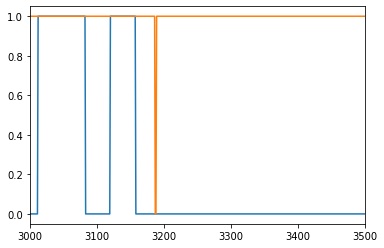

In [10]:
plt.plot(mask_elem)
plt.plot(mask_spectra)

plt.xlim(3000,3500)

In [11]:
from apogee.tools import bitmask

import random
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn

from apoNN.src.datasets import ApogeeDataset,AspcapDataset
from apoNN.src.utils import generate_loss_with_masking

from tagging.src.networks import ConditioningAutoencoder,Embedding_Decoder,Feedforward,ParallelDecoder,Autoencoder

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
apogee_path.change_dr(16)



In [27]:

n_batch = 256
n_z = 5
n_bins = 8575
lr = 0.0001
dataset_name = "aspcap_restricted"
dataset_outputs = ["aspcap","mask2","physical","idx"]
loss = "l2"
use_masked_loss = True
savename = "ae"
encoder_architecture = [n_bins,1024,256,n_z]
decoder_architecture = [n_z,128,256,np.sum(mask_elem).astype(int)]
activation = nn.SELU()
recenter=True


In [28]:
dataset = AspcapDataset(filename=dataset_name,recenter=recenter)

loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = n_batch,
                                     shuffle= True,
                                     drop_last=True)


encoder = Feedforward(encoder_architecture ,activation=activation).to(device)
decoder = Feedforward(decoder_architecture ,activation=activation).to(device)

autoencoder = Autoencoder(encoder,decoder,n_bins=n_bins,intermediate_activation=activation).to(device)
optimizer_autoencoder = torch.optim.Adam(autoencoder.parameters(), lr=lr)




In [29]:

if loss == "l1":
    loss = nn.L1Loss()
elif loss == "l2":
    loss = nn.MSELoss()

if use_masked_loss:
    masked_loss = generate_loss_with_masking(loss)



In [30]:
t_mask_elem = torch.tensor(mask_elem).repeat(n_batch,1).type(torch.bool)

In [31]:
for i in range(30000):
    if i%250==0:
        torch.save(autoencoder,f"{savename}_{i}.p")

    for j,(x,x_raw,x_err,idx) in enumerate(loader):
        optimizer_autoencoder.zero_grad()
        x_pred,z = autoencoder(x.to(device))
        x_window = x[t_mask_elem].reshape(n_batch,np.sum(mask_elem).astype(int))
        if use_masked_loss:
            mask = x_err<dataset.err_threshold
            mask_window = mask[t_mask_elem].reshape(n_batch,np.sum(mask_elem).astype(int))

            err_pred = masked_loss(x_pred,x_window.to(device),mask_window)
        else:
            err_pred = loss(x_pred,x_window.to(device))

        err_tot = err_pred
        err_tot.backward()
        optimizer_autoencoder.step()
        if j%100==0:
            print(f"err:{err_tot},err_pred:{err_pred}")
                 

err:0.022530512884259224,err_pred:0.022530512884259224
err:0.0007211774936877191,err_pred:0.0007211774936877191
err:0.0005452292389236391,err_pred:0.0005452292389236391
err:0.00048429201706312597,err_pred:0.00048429201706312597
err:0.0003967182128690183,err_pred:0.0003967182128690183
err:0.00031364444294013083,err_pred:0.00031364444294013083
err:0.0002496403467375785,err_pred:0.0002496403467375785
err:0.000203647228772752,err_pred:0.000203647228772752
err:0.0001740197476465255,err_pred:0.0001740197476465255
err:0.00015672881272621453,err_pred:0.00015672881272621453
err:0.00014754269795957953,err_pred:0.00014754269795957953
err:0.0001433044672012329,err_pred:0.0001433044672012329
err:0.00014379940694198012,err_pred:0.00014379940694198012
err:0.0001397269224980846,err_pred:0.0001397269224980846
err:0.00013962392404209822,err_pred:0.00013962392404209822
err:0.00013597025827039033,err_pred:0.00013597025827039033
err:0.0001357669971184805,err_pred:0.0001357669971184805
err:0.000135417343699

err:9.403023432241753e-05,err_pred:9.403023432241753e-05
err:9.396146197104827e-05,err_pred:9.396146197104827e-05
err:9.40874160733074e-05,err_pred:9.40874160733074e-05
err:9.42672704695724e-05,err_pred:9.42672704695724e-05
err:9.4237009761855e-05,err_pred:9.4237009761855e-05
err:9.422437142347917e-05,err_pred:9.422437142347917e-05
err:9.407461766386405e-05,err_pred:9.407461766386405e-05
err:9.386881720274687e-05,err_pred:9.386881720274687e-05
err:9.371023043058813e-05,err_pred:9.371023043058813e-05
err:9.343479905510321e-05,err_pred:9.343479905510321e-05
err:9.31599352043122e-05,err_pred:9.31599352043122e-05
err:9.297121141571552e-05,err_pred:9.297121141571552e-05
err:9.298594522988424e-05,err_pred:9.298594522988424e-05
err:9.294670599047095e-05,err_pred:9.294670599047095e-05
err:9.287112334277481e-05,err_pred:9.287112334277481e-05
err:9.297665383201092e-05,err_pred:9.297665383201092e-05
err:9.310362656833604e-05,err_pred:9.310362656833604e-05
err:9.316013165516779e-05,err_pred:9.3160

err:8.917567902244627e-05,err_pred:8.917567902244627e-05
err:8.916475053410977e-05,err_pred:8.916475053410977e-05
err:8.923088171286508e-05,err_pred:8.923088171286508e-05
err:8.924958092393354e-05,err_pred:8.924958092393354e-05
err:8.929904288379475e-05,err_pred:8.929904288379475e-05
err:8.93658070708625e-05,err_pred:8.93658070708625e-05
err:8.935201185522601e-05,err_pred:8.935201185522601e-05
err:8.929736213758588e-05,err_pred:8.929736213758588e-05
err:8.922992128646001e-05,err_pred:8.922992128646001e-05
err:8.913852070691064e-05,err_pred:8.913852070691064e-05
err:8.903381967684254e-05,err_pred:8.903381967684254e-05
err:8.897829684428871e-05,err_pred:8.897829684428871e-05
err:8.8801360107027e-05,err_pred:8.8801360107027e-05
err:8.88827198650688e-05,err_pred:8.88827198650688e-05
err:8.87764836079441e-05,err_pred:8.87764836079441e-05
err:8.890251774573699e-05,err_pred:8.890251774573699e-05
err:8.897124644136056e-05,err_pred:8.897124644136056e-05
err:8.906650327844545e-05,err_pred:8.9066

err:8.873818296706304e-05,err_pred:8.873818296706304e-05
err:8.87440619408153e-05,err_pred:8.87440619408153e-05
err:8.860432717483491e-05,err_pred:8.860432717483491e-05
err:8.859045192366466e-05,err_pred:8.859045192366466e-05
err:8.857404463924468e-05,err_pred:8.857404463924468e-05
err:8.845418051350862e-05,err_pred:8.845418051350862e-05
err:8.845675620250404e-05,err_pred:8.845675620250404e-05
err:8.838531357469037e-05,err_pred:8.838531357469037e-05
err:8.852533210301772e-05,err_pred:8.852533210301772e-05
err:8.826684643281624e-05,err_pred:8.826684643281624e-05
err:8.838151552481577e-05,err_pred:8.838151552481577e-05
err:8.82393796928227e-05,err_pred:8.82393796928227e-05
err:8.834623440634459e-05,err_pred:8.834623440634459e-05
err:8.813022577669472e-05,err_pred:8.813022577669472e-05
err:8.821950905257836e-05,err_pred:8.821950905257836e-05
err:8.804539538687095e-05,err_pred:8.804539538687095e-05
err:8.818267815513536e-05,err_pred:8.818267815513536e-05
err:8.807171252556145e-05,err_pred:

err:8.71222437126562e-05,err_pred:8.71222437126562e-05
err:8.7138861999847e-05,err_pred:8.7138861999847e-05
err:8.713854185771197e-05,err_pred:8.713854185771197e-05
err:8.698538294993341e-05,err_pred:8.698538294993341e-05
err:8.707372035132721e-05,err_pred:8.707372035132721e-05
err:8.699616591911763e-05,err_pred:8.699616591911763e-05
err:8.693668496562168e-05,err_pred:8.693668496562168e-05
err:8.700403850525618e-05,err_pred:8.700403850525618e-05
err:8.677969890413806e-05,err_pred:8.677969890413806e-05
err:8.676401193952188e-05,err_pred:8.676401193952188e-05
err:8.686991350259632e-05,err_pred:8.686991350259632e-05
err:8.699827594682574e-05,err_pred:8.699827594682574e-05
err:8.694616553839296e-05,err_pred:8.694616553839296e-05
err:8.709995017852634e-05,err_pred:8.709995017852634e-05
err:8.721095946384594e-05,err_pred:8.721095946384594e-05
err:8.688537491252646e-05,err_pred:8.688537491252646e-05
err:8.71307565830648e-05,err_pred:8.71307565830648e-05
err:8.721609628992155e-05,err_pred:8.72

err:8.500507829012349e-05,err_pred:8.500507829012349e-05
err:8.499823161400855e-05,err_pred:8.499823161400855e-05
err:8.487427840009332e-05,err_pred:8.487427840009332e-05
err:8.489327592542395e-05,err_pred:8.489327592542395e-05
err:8.486359001835808e-05,err_pred:8.486359001835808e-05
err:8.482559496769682e-05,err_pred:8.482559496769682e-05
err:8.477748633595183e-05,err_pred:8.477748633595183e-05
err:8.482082193950191e-05,err_pred:8.482082193950191e-05
err:8.483474084641784e-05,err_pred:8.483474084641784e-05
err:8.477969822706655e-05,err_pred:8.477969822706655e-05
err:8.491359039908275e-05,err_pred:8.491359039908275e-05
err:8.488195453537628e-05,err_pred:8.488195453537628e-05
err:8.484788850182667e-05,err_pred:8.484788850182667e-05
err:8.481856639264151e-05,err_pred:8.481856639264151e-05
err:8.481524128001183e-05,err_pred:8.481524128001183e-05
err:8.488771709380671e-05,err_pred:8.488771709380671e-05
err:8.489598985761404e-05,err_pred:8.489598985761404e-05
err:8.497044473187998e-05,err_p

err:8.350020652869716e-05,err_pred:8.350020652869716e-05
err:8.349028212251142e-05,err_pred:8.349028212251142e-05
err:8.353927114512771e-05,err_pred:8.353927114512771e-05
err:8.350440475624055e-05,err_pred:8.350440475624055e-05
err:8.356292528333142e-05,err_pred:8.356292528333142e-05
err:8.354790770681575e-05,err_pred:8.354790770681575e-05
err:8.359736239071935e-05,err_pred:8.359736239071935e-05
err:8.358321792911738e-05,err_pred:8.358321792911738e-05
err:8.3612983871717e-05,err_pred:8.3612983871717e-05
err:8.357626211363822e-05,err_pred:8.357626211363822e-05
err:8.366164547624066e-05,err_pred:8.366164547624066e-05
err:8.359503408428282e-05,err_pred:8.359503408428282e-05
err:8.361302752746269e-05,err_pred:8.361302752746269e-05
err:8.356663602171466e-05,err_pred:8.356663602171466e-05
err:8.363643428310752e-05,err_pred:8.363643428310752e-05
err:8.367728150915354e-05,err_pred:8.367728150915354e-05
err:8.363539382116869e-05,err_pred:8.363539382116869e-05
err:8.35816899780184e-05,err_pred:8

err:8.37987317936495e-05,err_pred:8.37987317936495e-05
err:8.380463987123221e-05,err_pred:8.380463987123221e-05
err:8.387594425585121e-05,err_pred:8.387594425585121e-05
err:8.388319110963494e-05,err_pred:8.388319110963494e-05
err:8.38994892546907e-05,err_pred:8.38994892546907e-05
err:8.377121412195265e-05,err_pred:8.377121412195265e-05
err:8.37517945910804e-05,err_pred:8.37517945910804e-05
err:8.373518357984722e-05,err_pred:8.373518357984722e-05
err:8.379371865885332e-05,err_pred:8.379371865885332e-05
err:8.374695607926697e-05,err_pred:8.374695607926697e-05
err:8.373823220608756e-05,err_pred:8.373823220608756e-05
err:8.371873263968155e-05,err_pred:8.371873263968155e-05
err:8.361032814718783e-05,err_pred:8.361032814718783e-05
err:8.353426528628916e-05,err_pred:8.353426528628916e-05
err:8.341602369910106e-05,err_pred:8.341602369910106e-05
err:8.344982052221894e-05,err_pred:8.344982052221894e-05
err:8.314983278978616e-05,err_pred:8.314983278978616e-05
err:8.309675467899069e-05,err_pred:8.

err:8.314378646900877e-05,err_pred:8.314378646900877e-05
err:8.323505608132109e-05,err_pred:8.323505608132109e-05
err:8.334726589964703e-05,err_pred:8.334726589964703e-05
err:8.312008139910176e-05,err_pred:8.312008139910176e-05
err:8.315422746818513e-05,err_pred:8.315422746818513e-05
err:8.320200868183747e-05,err_pred:8.320200868183747e-05
err:8.337208419106901e-05,err_pred:8.337208419106901e-05
err:8.336779137607664e-05,err_pred:8.336779137607664e-05
err:8.332736615557224e-05,err_pred:8.332736615557224e-05
err:8.347259426955134e-05,err_pred:8.347259426955134e-05
err:8.37531842989847e-05,err_pred:8.37531842989847e-05
err:8.394689939450473e-05,err_pred:8.394689939450473e-05
err:8.440409146714956e-05,err_pred:8.440409146714956e-05
err:8.45063041197136e-05,err_pred:8.45063041197136e-05
err:8.431805326836184e-05,err_pred:8.431805326836184e-05
err:8.391437586396933e-05,err_pred:8.391437586396933e-05
err:8.365078247152269e-05,err_pred:8.365078247152269e-05
err:8.351861470146105e-05,err_pred:

err:8.301282650791109e-05,err_pred:8.301282650791109e-05
err:8.305499068228528e-05,err_pred:8.305499068228528e-05
err:8.307820826303214e-05,err_pred:8.307820826303214e-05
err:8.298012835439295e-05,err_pred:8.298012835439295e-05
err:8.289430843433365e-05,err_pred:8.289430843433365e-05
err:8.290344703709707e-05,err_pred:8.290344703709707e-05
err:8.289260586025193e-05,err_pred:8.289260586025193e-05
err:8.286126831080765e-05,err_pred:8.286126831080765e-05
err:8.283500937977806e-05,err_pred:8.283500937977806e-05
err:8.27990734251216e-05,err_pred:8.27990734251216e-05
err:8.283007628051564e-05,err_pred:8.283007628051564e-05
err:8.277520828414708e-05,err_pred:8.277520828414708e-05
err:8.276668813778087e-05,err_pred:8.276668813778087e-05
err:8.277103188447654e-05,err_pred:8.277103188447654e-05
err:8.269184036180377e-05,err_pred:8.269184036180377e-05
err:8.274032006738707e-05,err_pred:8.274032006738707e-05
err:8.272834384115413e-05,err_pred:8.272834384115413e-05
err:8.271732804132625e-05,err_pre

err:8.240161696448922e-05,err_pred:8.240161696448922e-05
err:8.237637666752562e-05,err_pred:8.237637666752562e-05
err:8.240874740295112e-05,err_pred:8.240874740295112e-05
err:8.25572496978566e-05,err_pred:8.25572496978566e-05
err:8.256446744780988e-05,err_pred:8.256446744780988e-05
err:8.246995275840163e-05,err_pred:8.246995275840163e-05
err:8.25569877633825e-05,err_pred:8.25569877633825e-05
err:8.256790169980377e-05,err_pred:8.256790169980377e-05
err:8.246096695074812e-05,err_pred:8.246096695074812e-05
err:8.232592517742887e-05,err_pred:8.232592517742887e-05
err:8.23168593342416e-05,err_pred:8.23168593342416e-05
err:8.229663217207417e-05,err_pred:8.229663217207417e-05
err:8.225089550251141e-05,err_pred:8.225089550251141e-05
err:8.234376582549885e-05,err_pred:8.234376582549885e-05
err:8.222091855714098e-05,err_pred:8.222091855714098e-05
err:8.227659418480471e-05,err_pred:8.227659418480471e-05
err:8.220793824875727e-05,err_pred:8.220793824875727e-05
err:8.230272942455485e-05,err_pred:8.

err:8.167535270331427e-05,err_pred:8.167535270331427e-05
err:8.171703666448593e-05,err_pred:8.171703666448593e-05
err:8.170225191861391e-05,err_pred:8.170225191861391e-05
err:8.172602247213945e-05,err_pred:8.172602247213945e-05
err:8.183072350220755e-05,err_pred:8.183072350220755e-05
err:8.186521154129878e-05,err_pred:8.186521154129878e-05
err:8.187691128114238e-05,err_pred:8.187691128114238e-05
err:8.197212446248159e-05,err_pred:8.197212446248159e-05
err:8.198020805139095e-05,err_pred:8.198020805139095e-05
err:8.199166040867567e-05,err_pred:8.199166040867567e-05
err:8.212285320041701e-05,err_pred:8.212285320041701e-05
err:8.208867802750319e-05,err_pred:8.208867802750319e-05
err:8.22005167719908e-05,err_pred:8.22005167719908e-05
err:8.222561882575974e-05,err_pred:8.222561882575974e-05
err:8.226764475693926e-05,err_pred:8.226764475693926e-05
err:8.21377252577804e-05,err_pred:8.21377252577804e-05
err:8.217813592636958e-05,err_pred:8.217813592636958e-05
err:8.21336725493893e-05,err_pred:8

err:8.343879744643345e-05,err_pred:8.343879744643345e-05
err:8.325698581757024e-05,err_pred:8.325698581757024e-05
err:8.309848635690287e-05,err_pred:8.309848635690287e-05
err:8.328878175234422e-05,err_pred:8.328878175234422e-05
err:8.324657392222434e-05,err_pred:8.324657392222434e-05
err:8.335931488545612e-05,err_pred:8.335931488545612e-05
err:8.32189034554176e-05,err_pred:8.32189034554176e-05
err:8.319037442561239e-05,err_pred:8.319037442561239e-05
err:8.281337795779109e-05,err_pred:8.281337795779109e-05
err:8.27665498945862e-05,err_pred:8.27665498945862e-05
err:8.268954115919769e-05,err_pred:8.268954115919769e-05
err:8.273408457171172e-05,err_pred:8.273408457171172e-05
err:8.271393016912043e-05,err_pred:8.271393016912043e-05
err:8.26037721708417e-05,err_pred:8.26037721708417e-05
err:8.259878086391836e-05,err_pred:8.259878086391836e-05
err:8.24986636871472e-05,err_pred:8.24986636871472e-05
err:8.239762973971665e-05,err_pred:8.239762973971665e-05
err:8.233472908614203e-05,err_pred:8.23

err:8.121396967908368e-05,err_pred:8.121396967908368e-05
err:8.110787894111127e-05,err_pred:8.110787894111127e-05
err:8.107531175483018e-05,err_pred:8.107531175483018e-05
err:8.10707570053637e-05,err_pred:8.10707570053637e-05
err:8.103527216007933e-05,err_pred:8.103527216007933e-05
err:8.097101090243086e-05,err_pred:8.097101090243086e-05
err:8.089707262115553e-05,err_pred:8.089707262115553e-05
err:8.079679537331685e-05,err_pred:8.079679537331685e-05
err:8.076562517089769e-05,err_pred:8.076562517089769e-05
err:8.083563443506137e-05,err_pred:8.083563443506137e-05
err:8.090987830655649e-05,err_pred:8.090987830655649e-05
err:8.09354314696975e-05,err_pred:8.09354314696975e-05
err:8.102293941192329e-05,err_pred:8.102293941192329e-05
err:8.103006985038519e-05,err_pred:8.103006985038519e-05
err:8.1033977039624e-05,err_pred:8.1033977039624e-05
err:8.102152060018852e-05,err_pred:8.102152060018852e-05
err:8.099437400233e-05,err_pred:8.099437400233e-05
err:8.093078940873966e-05,err_pred:8.09307894

err:8.225647616200149e-05,err_pred:8.225647616200149e-05
err:8.220978634199128e-05,err_pred:8.220978634199128e-05
err:8.1920217780862e-05,err_pred:8.1920217780862e-05
err:8.1718921137508e-05,err_pred:8.1718921137508e-05
err:8.165022154571488e-05,err_pred:8.165022154571488e-05
err:8.163971506292e-05,err_pred:8.163971506292e-05
err:8.165180770447478e-05,err_pred:8.165180770447478e-05
err:8.168140630004928e-05,err_pred:8.168140630004928e-05
err:8.17456457298249e-05,err_pred:8.17456457298249e-05
err:8.183174941223115e-05,err_pred:8.183174941223115e-05
err:8.179866563295946e-05,err_pred:8.179866563295946e-05
err:8.189750951714814e-05,err_pred:8.189750951714814e-05
err:8.185197657439858e-05,err_pred:8.185197657439858e-05
err:8.18038679426536e-05,err_pred:8.18038679426536e-05
err:8.182889723684639e-05,err_pred:8.182889723684639e-05
err:8.187525236280635e-05,err_pred:8.187525236280635e-05
err:8.189531217794865e-05,err_pred:8.189531217794865e-05
err:8.178513962775469e-05,err_pred:8.178513962775

err:8.091818017419428e-05,err_pred:8.091818017419428e-05
err:8.086442539934069e-05,err_pred:8.086442539934069e-05
err:8.088332106126472e-05,err_pred:8.088332106126472e-05
err:8.082500426098704e-05,err_pred:8.082500426098704e-05
err:8.074919605860487e-05,err_pred:8.074919605860487e-05
err:8.076419908320531e-05,err_pred:8.076419908320531e-05
err:8.085047011263669e-05,err_pred:8.085047011263669e-05
err:8.092621283140033e-05,err_pred:8.092621283140033e-05
err:8.091243944363669e-05,err_pred:8.091243944363669e-05
err:8.100366540020332e-05,err_pred:8.100366540020332e-05
err:8.090163464657962e-05,err_pred:8.090163464657962e-05
err:8.095868543023244e-05,err_pred:8.095868543023244e-05
err:8.09709308668971e-05,err_pred:8.09709308668971e-05
err:8.105853339657187e-05,err_pred:8.105853339657187e-05
err:8.109889313345775e-05,err_pred:8.109889313345775e-05
err:8.122748840833083e-05,err_pred:8.122748840833083e-05
err:8.124844316625968e-05,err_pred:8.124844316625968e-05
err:8.132256334647536e-05,err_pre

err:8.201297168852761e-05,err_pred:8.201297168852761e-05
err:8.189674554159865e-05,err_pred:8.189674554159865e-05
err:8.247466030297801e-05,err_pred:8.247466030297801e-05
err:8.215986599680036e-05,err_pred:8.215986599680036e-05
err:8.212873945012689e-05,err_pred:8.212873945012689e-05
err:8.220448216889054e-05,err_pred:8.220448216889054e-05
err:8.22018992039375e-05,err_pred:8.22018992039375e-05
err:8.233674452640116e-05,err_pred:8.233674452640116e-05
err:8.216343849198893e-05,err_pred:8.216343849198893e-05
err:8.207310747820884e-05,err_pred:8.207310747820884e-05
err:8.179595897672698e-05,err_pred:8.179595897672698e-05
err:8.155140676535666e-05,err_pred:8.155140676535666e-05
err:8.130198693834245e-05,err_pred:8.130198693834245e-05
err:8.139500278048217e-05,err_pred:8.139500278048217e-05
err:8.158064883900806e-05,err_pred:8.158064883900806e-05
err:8.174060349119827e-05,err_pred:8.174060349119827e-05
err:8.18035623524338e-05,err_pred:8.18035623524338e-05
err:8.160783909261227e-05,err_pred:

err:8.087410969892517e-05,err_pred:8.087410969892517e-05
err:8.084531873464584e-05,err_pred:8.084531873464584e-05
err:8.075978985289112e-05,err_pred:8.075978985289112e-05
err:8.073252683971077e-05,err_pred:8.073252683971077e-05
err:8.074464130913839e-05,err_pred:8.074464130913839e-05
err:8.064448775257915e-05,err_pred:8.064448775257915e-05
err:8.058531966526061e-05,err_pred:8.058531966526061e-05
err:8.058974344749004e-05,err_pred:8.058974344749004e-05
err:8.049230382312089e-05,err_pred:8.049230382312089e-05
err:8.049513417063281e-05,err_pred:8.049513417063281e-05
err:8.050955511862412e-05,err_pred:8.050955511862412e-05
err:8.052272460190579e-05,err_pred:8.052272460190579e-05
err:8.060999243753031e-05,err_pred:8.060999243753031e-05
err:8.071372576523572e-05,err_pred:8.071372576523572e-05
err:8.075221558101475e-05,err_pred:8.075221558101475e-05
err:8.081508713075891e-05,err_pred:8.081508713075891e-05
err:8.087599417194724e-05,err_pred:8.087599417194724e-05
err:8.090258052106947e-05,err_p

err:8.059754327405244e-05,err_pred:8.059754327405244e-05
err:8.065780275501311e-05,err_pred:8.065780275501311e-05
err:8.071532647591084e-05,err_pred:8.071532647591084e-05
err:8.079539838945493e-05,err_pred:8.079539838945493e-05
err:8.094211807474494e-05,err_pred:8.094211807474494e-05
err:8.106474706437439e-05,err_pred:8.106474706437439e-05
err:8.095699013210833e-05,err_pred:8.095699013210833e-05
err:8.088599861366674e-05,err_pred:8.088599861366674e-05
err:8.072284981608391e-05,err_pred:8.072284981608391e-05
err:8.078887913143262e-05,err_pred:8.078887913143262e-05
err:8.090144547168165e-05,err_pred:8.090144547168165e-05
err:8.079261897364631e-05,err_pred:8.079261897364631e-05
err:8.093742508208379e-05,err_pred:8.093742508208379e-05
err:8.08362674433738e-05,err_pred:8.08362674433738e-05
err:8.094959775917232e-05,err_pred:8.094959775917232e-05
err:8.099850674625486e-05,err_pred:8.099850674625486e-05
err:8.102801075438038e-05,err_pred:8.102801075438038e-05
err:8.10066849226132e-05,err_pred

err:8.063188579399139e-05,err_pred:8.063188579399139e-05
err:8.058267849264666e-05,err_pred:8.058267849264666e-05
err:8.061367407208309e-05,err_pred:8.061367407208309e-05
err:8.051265467656776e-05,err_pred:8.051265467656776e-05
err:8.064142457442358e-05,err_pred:8.064142457442358e-05
err:8.068731403909624e-05,err_pred:8.068731403909624e-05
err:8.06726238806732e-05,err_pred:8.06726238806732e-05
err:8.073273056652397e-05,err_pred:8.073273056652397e-05
err:8.072860509855673e-05,err_pred:8.072860509855673e-05
err:8.074779907474294e-05,err_pred:8.074779907474294e-05
err:8.072600030573085e-05,err_pred:8.072600030573085e-05
err:8.068468741839752e-05,err_pred:8.068468741839752e-05
err:8.068732131505385e-05,err_pred:8.068732131505385e-05
err:8.064925350481644e-05,err_pred:8.064925350481644e-05
err:8.06917087174952e-05,err_pred:8.06917087174952e-05
err:8.054219506448135e-05,err_pred:8.054219506448135e-05
err:8.052156044868752e-05,err_pred:8.052156044868752e-05
err:8.048926247283816e-05,err_pred:

err:7.996887143235654e-05,err_pred:7.996887143235654e-05
err:7.985762204043567e-05,err_pred:7.985762204043567e-05
err:7.97714019427076e-05,err_pred:7.97714019427076e-05
err:7.983935211086646e-05,err_pred:7.983935211086646e-05
err:7.986537093529478e-05,err_pred:7.986537093529478e-05
err:7.98161854618229e-05,err_pred:7.98161854618229e-05
err:7.970774458954111e-05,err_pred:7.970774458954111e-05
err:7.96865570009686e-05,err_pred:7.96865570009686e-05
err:7.96185850049369e-05,err_pred:7.96185850049369e-05
err:7.962068048072979e-05,err_pred:7.962068048072979e-05
err:7.965521945152432e-05,err_pred:7.965521945152432e-05
err:7.964259566506371e-05,err_pred:7.964259566506371e-05
err:7.959955837577581e-05,err_pred:7.959955837577581e-05
err:7.959944196045399e-05,err_pred:7.959944196045399e-05
err:7.957413617987186e-05,err_pred:7.957413617987186e-05
err:7.95232190284878e-05,err_pred:7.95232190284878e-05
err:7.948975689942017e-05,err_pred:7.948975689942017e-05
err:7.951397856231779e-05,err_pred:7.9513

err:7.863581413403153e-05,err_pred:7.863581413403153e-05
err:7.863207429181784e-05,err_pred:7.863207429181784e-05
err:7.858954631956294e-05,err_pred:7.858954631956294e-05
err:7.859889592509717e-05,err_pred:7.859889592509717e-05
err:7.860803452786058e-05,err_pred:7.860803452786058e-05
err:7.863474456826225e-05,err_pred:7.863474456826225e-05
err:7.86853488534689e-05,err_pred:7.86853488534689e-05
err:7.861846825107932e-05,err_pred:7.861846825107932e-05
err:7.857996388338506e-05,err_pred:7.857996388338506e-05
err:7.86104574217461e-05,err_pred:7.86104574217461e-05
err:7.86099917604588e-05,err_pred:7.86099917604588e-05
err:7.86170712672174e-05,err_pred:7.86170712672174e-05
err:7.863808423280716e-05,err_pred:7.863808423280716e-05
err:7.865271618356928e-05,err_pred:7.865271618356928e-05
err:7.880305929575115e-05,err_pred:7.880305929575115e-05
err:7.913599256426096e-05,err_pred:7.913599256426096e-05
err:7.958104106364772e-05,err_pred:7.958104106364772e-05
err:7.991824531927705e-05,err_pred:7.99

err:7.872737478464842e-05,err_pred:7.872737478464842e-05
err:7.865780935389921e-05,err_pred:7.865780935389921e-05
err:7.872846617829055e-05,err_pred:7.872846617829055e-05
err:7.86672972026281e-05,err_pred:7.86672972026281e-05
err:7.872316928114742e-05,err_pred:7.872316928114742e-05
err:7.866485248086974e-05,err_pred:7.866485248086974e-05
err:7.868742977734655e-05,err_pred:7.868742977734655e-05
err:7.867930253269151e-05,err_pred:7.867930253269151e-05
err:7.865325460443273e-05,err_pred:7.865325460443273e-05
err:7.864207873353735e-05,err_pred:7.864207873353735e-05
err:7.867375097703189e-05,err_pred:7.867375097703189e-05
err:7.874226866988465e-05,err_pred:7.874226866988465e-05
err:7.872803689679131e-05,err_pred:7.872803689679131e-05
err:7.87402896094136e-05,err_pred:7.87402896094136e-05
err:7.873401773395017e-05,err_pred:7.873401773395017e-05
err:7.866807573009282e-05,err_pred:7.866807573009282e-05
err:7.859314064262435e-05,err_pred:7.859314064262435e-05
err:7.8601275163237e-05,err_pred:7.

err:7.81333728809841e-05,err_pred:7.81333728809841e-05
err:7.814759010216221e-05,err_pred:7.814759010216221e-05
err:7.811472460161895e-05,err_pred:7.811472460161895e-05
err:7.814671698724851e-05,err_pred:7.814671698724851e-05
err:7.818625454092398e-05,err_pred:7.818625454092398e-05
err:7.8200115240179e-05,err_pred:7.8200115240179e-05
err:7.8281678725034e-05,err_pred:7.8281678725034e-05
err:7.824123895261437e-05,err_pred:7.824123895261437e-05
err:7.823281339369714e-05,err_pred:7.823281339369714e-05
err:7.825507054803893e-05,err_pred:7.825507054803893e-05
err:7.822331826901063e-05,err_pred:7.822331826901063e-05
err:7.832396659068763e-05,err_pred:7.832396659068763e-05
err:7.839420140953735e-05,err_pred:7.839420140953735e-05
err:7.845561776775867e-05,err_pred:7.845561776775867e-05
err:7.841784827178344e-05,err_pred:7.841784827178344e-05
err:7.840724720153958e-05,err_pred:7.840724720153958e-05
err:7.84239309723489e-05,err_pred:7.84239309723489e-05
err:7.838138117222115e-05,err_pred:7.838138

err:7.930843275971711e-05,err_pred:7.930843275971711e-05
err:7.916565664345399e-05,err_pred:7.916565664345399e-05
err:7.923128578113392e-05,err_pred:7.923128578113392e-05
err:7.911608554422855e-05,err_pred:7.911608554422855e-05
err:7.922499935375527e-05,err_pred:7.922499935375527e-05
err:7.914302841527387e-05,err_pred:7.914302841527387e-05
err:7.905651727924123e-05,err_pred:7.905651727924123e-05
err:7.90037665865384e-05,err_pred:7.90037665865384e-05
err:7.871011621318758e-05,err_pred:7.871011621318758e-05
err:7.86640594014898e-05,err_pred:7.86640594014898e-05
err:7.855179137550294e-05,err_pred:7.855179137550294e-05
err:7.867687963880599e-05,err_pred:7.867687963880599e-05
err:7.867895328672603e-05,err_pred:7.867895328672603e-05
err:7.872170681366697e-05,err_pred:7.872170681366697e-05
err:7.85842930781655e-05,err_pred:7.85842930781655e-05
err:7.860857294872403e-05,err_pred:7.860857294872403e-05
err:7.865284715080634e-05,err_pred:7.865284715080634e-05
err:7.862869824748486e-05,err_pred:7.

err:7.850766269257292e-05,err_pred:7.850766269257292e-05
err:7.87154131103307e-05,err_pred:7.87154131103307e-05
err:7.884614024078473e-05,err_pred:7.884614024078473e-05
err:7.868991087889299e-05,err_pred:7.868991087889299e-05
err:7.866219675634056e-05,err_pred:7.866219675634056e-05
err:7.84286530688405e-05,err_pred:7.84286530688405e-05
err:7.84322910476476e-05,err_pred:7.84322910476476e-05
err:7.847238157410175e-05,err_pred:7.847238157410175e-05
err:7.854208524804562e-05,err_pred:7.854208524804562e-05
err:7.865465158829466e-05,err_pred:7.865465158829466e-05
err:7.847077358746901e-05,err_pred:7.847077358746901e-05
err:7.844017818570137e-05,err_pred:7.844017818570137e-05
err:7.840014586690813e-05,err_pred:7.840014586690813e-05
err:7.833762356312945e-05,err_pred:7.833762356312945e-05
err:7.823828491382301e-05,err_pred:7.823828491382301e-05
err:7.818015001248568e-05,err_pred:7.818015001248568e-05
err:7.811574323568493e-05,err_pred:7.811574323568493e-05
err:7.809495582478121e-05,err_pred:7.

err:7.810356328263879e-05,err_pred:7.810356328263879e-05
err:7.799721788614988e-05,err_pred:7.799721788614988e-05
err:7.794990960974246e-05,err_pred:7.794990960974246e-05
err:7.788666698615998e-05,err_pred:7.788666698615998e-05
err:7.809524686308578e-05,err_pred:7.809524686308578e-05
err:7.817630103090778e-05,err_pred:7.817630103090778e-05
err:7.824823842383921e-05,err_pred:7.824823842383921e-05
err:7.821297185728326e-05,err_pred:7.821297185728326e-05
err:7.814989658072591e-05,err_pred:7.814989658072591e-05
err:7.815964636392891e-05,err_pred:7.815964636392891e-05
err:7.812923286110163e-05,err_pred:7.812923286110163e-05
err:7.817320147296414e-05,err_pred:7.817320147296414e-05
err:7.823620398994535e-05,err_pred:7.823620398994535e-05
err:7.834357529645786e-05,err_pred:7.834357529645786e-05
err:7.832337723812088e-05,err_pred:7.832337723812088e-05
err:7.826453656889498e-05,err_pred:7.826453656889498e-05
err:7.82800925662741e-05,err_pred:7.82800925662741e-05
err:7.829222158761695e-05,err_pre

KeyboardInterrupt: 

In [32]:
x_pred[mask_elem].shape

torch.Size([8575, 212])

In [33]:
np.sum(mask_elem)

212.0

In [34]:
mask.shape

torch.Size([256, 8575])

In [36]:
old_autoencoder = torch.load("/share/splinter/ddm/taggingProject/apogeeFactory/outputs/guild/aspcap/dim/z5b/ae_7000.p")


In [37]:
        x_pred,z = autoencoder(x.to(device))
        x_window = x[t_mask_elem].reshape(n_batch,np.sum(mask_elem).astype(int))
        mask_window = mask[t_mask_elem].reshape(n_batch,np.sum(mask_elem).astype(int))


(5860, 5900)

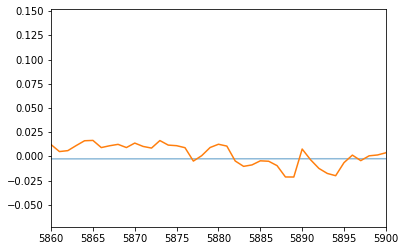

In [38]:
plt.plot(np.where(mask_elem==1)[0],x_window.detach().cpu().numpy()[1],alpha=0.5,marker="x")
plt.plot(x[1])
plt.xlim(5860,5900)

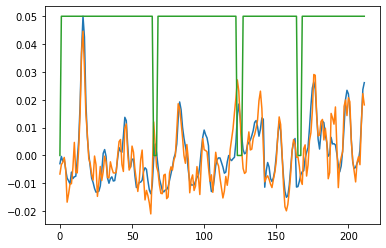

In [39]:
i = 0
plt.plot(x_pred.detach().cpu().numpy()[i])
plt.plot(x_window.detach().cpu().numpy()[i])
plt.plot(mask_window.detach().cpu().numpy()[i]*0.05)


In [40]:
x_pred_old,z_old = old_autoencoder(x.to(device))
x_pred_old_window = x_pred_old[t_mask_elem].reshape(n_batch,np.sum(mask_elem).astype(int))


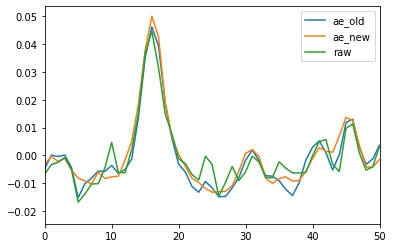

In [43]:
plt.plot(x_pred_old_window.detach().cpu().numpy()[i],label="ae_old")
plt.plot(x_pred.detach().cpu().numpy()[i],label="ae_new")
plt.plot(x_window.detach().cpu().numpy()[i],label="raw")
#plt.plot(mask_window.detach().cpu().numpy()[i]*0.05)
plt.xlim(0,50)
plt.legend()

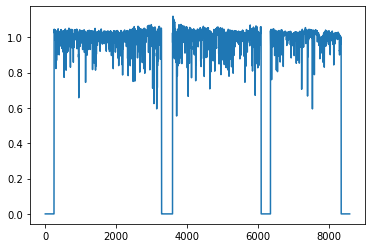

In [44]:
a= x_pred_old.detach().cpu().numpy()+np.mean(dataset.dataset["aspcap_interpolated"],axis=0)

plt.plot(a[0])

In [45]:
a= x_pred_old.detach().cpu().numpy()+np.mean(dataset.dataset["aspcap_interpolated"],axis=0)
a.shape

(256, 8575)

### Compare and visualize outputs

In [46]:
substracted_mean = np.mean(dataset.dataset["aspcap_interpolated"],axis=0)
substracted_mean_window = substracted_mean[mask_elem.astype(bool)]

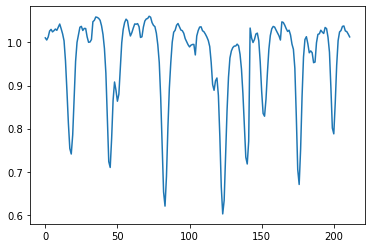

In [47]:
plt.plot(x_window.detach().cpu().numpy()[i]+substracted_mean_window,label="raw")


In [48]:
x_raw_window = dataset.dataset["aspcap"][i][mask_elem.astype(bool)]


In [50]:
i=28
x_pred_old,_ = old_autoencoder(x.to(device))
x_pred,_ = autoencoder(x.to(device))
x_window = x[t_mask_elem].reshape(n_batch,np.sum(mask_elem).astype(int))
mask = x_err<dataset.err_threshold
mask_window = mask[t_mask_elem].reshape(n_batch,np.sum(mask_elem).astype(int))
x_pred_old_window = x_pred_old[t_mask_elem].reshape(n_batch,np.sum(mask_elem).astype(int))
substracted_mean = np.mean(dataset.dataset["aspcap_interpolated"],axis=0)
substracted_mean_window = substracted_mean[mask_elem.astype(bool)]

In [51]:
def plot_window(x,mask_elem,idx=0,label=None):
    if torch.is_tensor(x):
        x = x.detach().cpu().numpy()
    t_mask_elem = torch.tensor(mask_elem).repeat(n_batch,1).type(torch.bool)
    x_window = x[t_mask_elem].reshape(n_batch,np.sum(mask_elem).astype(int))
    plt.plot(x_window[idx],label=label)

    
        

(180, 190)

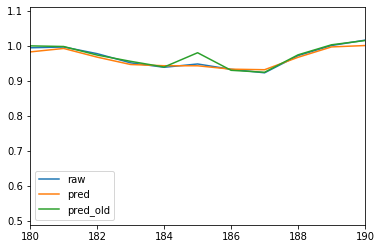

In [60]:
x_raw_window = dataset.dataset["aspcap"][idx[i].item()][mask_elem.astype(bool)]
plt.plot(x_window.detach().cpu().numpy()[i]+substracted_mean_window,label="raw")
#plt.plot(x_raw_window,label="raw")
plt.plot(x_pred.detach().cpu().numpy()[i]+substracted_mean_window,label="pred")
plt.plot(x_pred_old_window.detach().cpu().numpy()[i]+substracted_mean_window,label="pred_old")
#plt.plot(mask_window[i])
plt.legend()
plt.xlim(180,190)

(5868, 5954)

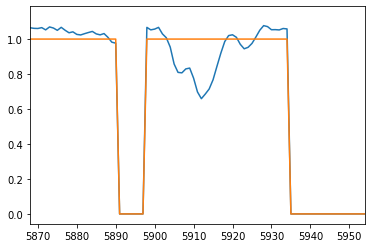

In [61]:
raw = dataset.dataset["aspcap"][i]
err = dataset.dataset["aspcap_err"][i]
mask = err<dataset.err_threshold

plt.plot(dataset.dataset["aspcap"][i])
plt.plot(mask)
plt.xlim(5868,5954)

### Extracting NA

In [62]:
import apoNN.src.vectors as vector

z = vector.LatentVector(dataset,autoencoder,n_data)


/share/splinter/ddm/taggingProject/apogeeFactory/apoNN/src/vectors.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _,z = self.autoencoder(torch.tensor(self.dataset[idx][0]).to(device).unsqueeze(0))



/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.



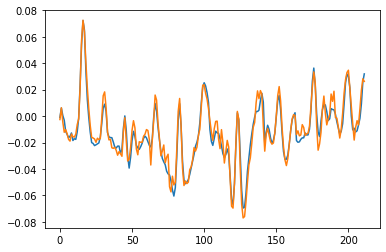

In [63]:
x_test=  torch.tensor(dataset[0:1][0]).to(device)
x_test_pred,z_test = autoencoder(x_test)
x_window = x_test[t_mask_elem[0:1,:]].reshape(1,np.sum(mask_elem).astype(int))

plt.plot(x_test_pred[0].detach().cpu().numpy())
plt.plot(x_window[0].detach().cpu().numpy())

In [64]:
z_test

tensor([[ 0.2352, -0.0200, -0.1083, -0.0477, -0.0605]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [65]:
z.raw[0]

array([ 0.23522437, -0.01999608, -0.10825396, -0.0477326 , -0.0605422 ],
      dtype=float32)

In [3]:

upper_temp_cut = allStar["Teff"]<7000
lower_temp_cut = allStar["Teff"]>3500
lower_g_cut = allStar["logg"]>1.
upper_g_cut = allStar["logg"]<3.5
snr_cut = allStar["SNR"]>100
snr_highcut = allStar["SNR"]<500
feh_outliercut = allStar["Fe_H"]>-5
o_outliercut = allStar["O_FE"]>-5
c_outliercut = allStar["C_FE"]>-5
na_outliercut = allStar["Na_FE"]>-5
mg_outliercut = allStar["Mg_FE"]>-5
si_outliercut = allStar["Si_FE"]>-5
al_outliercut = allStar["Al_FE"]>-5
s_outliercut = allStar["S_FE"]>-5
p_outliercut = allStar["P_FE"]>-5
ti_outliercut = allStar["Ti_FE"]>-5
cr_outliercut = allStar["Cr_FE"]>-5



combined_cut = lower_g_cut & upper_g_cut & lower_temp_cut & upper_temp_cut & snr_cut & snr_highcut & feh_outliercut & o_outliercut &  c_outliercut & na_outliercut & mg_outliercut & si_outliercut & al_outliercut & p_outliercut & s_outliercut & ti_outliercut & cr_outliercut

considered_parameters = ["Teff","logg","Fe_H","O_FE","C_FE","Na_FE","Mg_FE","Si_FE","S_FE","Al_FE","P_FE","Ni_FE"] 
y = vector.Vector(np.array([allStar[:n_data][combined_cut[:n_data]][param] for param in considered_parameters])[:,:n_data].T)

NameError: name 'vector' is not defined

In [68]:
z = vector.Vector(z.raw[combined_cut[:n_data]])

In [69]:
w = vector.LinearTransformation(z,y)
nonlinear_w = vector.NonLinearTransformation(z,y)
nonlinear_w.fit(n_epochs=200)

err:0.04909505322575569
err:0.044636525213718414
err:0.04702731966972351
err:0.04245919734239578
err:0.039897654205560684
err:0.04420796036720276
err:0.03592121973633766
err:0.0395946204662323
err:0.038721825927495956
err:0.0392538420855999
err:0.03446255251765251
err:0.035922445356845856
err:0.03627697378396988
err:0.0280692670494318
err:0.04315099120140076
err:0.03490619361400604
err:0.025772960856556892
err:0.028640439733862877
err:0.022350048646330833
err:0.027170982211828232
err:0.026165494695305824
err:0.027717381715774536
err:0.026873808354139328
err:0.025329139083623886
err:0.02802484668791294
err:0.028920931741595268
err:0.026676109060645103
err:0.024508275091648102
err:0.026723207905888557
err:0.03368509188294411
err:0.03316916152834892
err:0.04141664877533913
err:0.03877131640911102
err:0.048819854855537415
err:0.032582178711891174
err:0.032513394951820374
err:0.04073319211602211
err:0.02878313697874546
err:0.030550923198461533
err:0.025264786556363106
err:0.0302924551069736

err:0.013721806928515434
err:0.015343019738793373
err:0.011810177005827427
err:0.014056805521249771
err:0.02478991262614727
err:0.011371990665793419
err:0.008597358129918575
err:0.01186045166105032
err:0.02326514944434166
err:0.01288765948265791
err:0.01460141222923994
err:0.01659928262233734
err:0.019819030538201332
err:0.013027646578848362
err:0.01715685985982418
err:0.013261448591947556
err:0.014115311205387115
err:0.015424800105392933
err:0.015197348780930042
err:0.015337079763412476
err:0.0141333332285285
err:0.016512634232640266
err:0.011693141423165798
err:0.01574798859655857
err:0.014291404746472836
err:0.011562924832105637
err:0.011140892282128334
err:0.00907540787011385
err:0.010424591600894928
err:0.011583719402551651
err:0.012033355422317982
err:0.013333718292415142
err:0.013082968071103096
err:0.011882518418133259
err:0.01209974940866232
err:0.011081915348768234
err:0.010296155698597431
err:0.013844099827110767
err:0.015878519043326378
err:0.01632572151720524
err:0.0223085

err:0.010560539551079273
err:0.012710560113191605
err:0.026350677013397217
err:0.010379444807767868
err:0.008052571676671505
err:0.010492180474102497
err:0.022388668730854988
err:0.011820496991276741
err:0.01384543627500534
err:0.015836887061595917
err:0.020390616729855537
err:0.012228542007505894
err:0.015908466652035713
err:0.012756244279444218
err:0.01325998455286026
err:0.014734319411218166
err:0.014615647494792938
err:0.014481023885309696
err:0.013208165764808655
err:0.0163702555000782
err:0.011252319440245628
err:0.014335724525153637
err:0.013443409465253353
err:0.011246244423091412
err:0.010424712672829628
err:0.008552896790206432
err:0.010046266950666904
err:0.011354409158229828
err:0.011973404325544834
err:0.01284867711365223
err:0.0125021543353796
err:0.011512430384755135
err:0.011604711413383484
err:0.010375207290053368
err:0.009721173904836178
err:0.013419157825410366
err:0.015613420866429806
err:0.01496108528226614
err:0.020799268037080765
err:0.01577593758702278
err:0.031

err:0.010103486478328705
err:0.007827583700418472
err:0.00991880428045988
err:0.021523693576455116
err:0.01122758537530899
err:0.013285310938954353
err:0.015230250544846058
err:0.019069258123636246
err:0.011805527843534946
err:0.015307989902794361
err:0.012444009073078632
err:0.01287052035331726
err:0.014194060117006302
err:0.014144957065582275
err:0.013896990567445755
err:0.012770656496286392
err:0.016141599044203758
err:0.011007308959960938
err:0.013732322491705418
err:0.013074715621769428
err:0.010992971248924732
err:0.010104604996740818
err:0.00829298235476017
err:0.009814784862101078
err:0.011106647551059723
err:0.011742094531655312
err:0.012468654662370682
err:0.012128449976444244
err:0.011153691448271275
err:0.011299002915620804
err:0.010173746384680271
err:0.009364629164338112
err:0.013016082346439362
err:0.015325403772294521
err:0.014252628199756145
err:0.0194888636469841
err:0.015227429568767548
err:0.02972298115491867
err:0.016182303428649902
err:0.02035238780081272
err:0.01

err:0.009419587440788746
err:0.020695237442851067
err:0.010672741569578648
err:0.01276966743171215
err:0.01474833395332098
err:0.017608201131224632
err:0.011466684751212597
err:0.0148124098777771
err:0.012152097187936306
err:0.01256297342479229
err:0.013672549277544022
err:0.013743562623858452
err:0.01340077631175518
err:0.012414878234267235
err:0.015929963439702988
err:0.010779249481856823
err:0.01326601393520832
err:0.012786719016730785
err:0.010781566612422466
err:0.009820348583161831
err:0.00805701408535242
err:0.009625031612813473
err:0.010898576118052006
err:0.01152863260358572
err:0.01212227251380682
err:0.01181758102029562
err:0.010853524319827557
err:0.011025491170585155
err:0.010015713050961494
err:0.009062657132744789
err:0.012623490765690804
err:0.015002268366515636
err:0.013642956502735615
err:0.018355432897806168
err:0.014775874093174934
err:0.027776848524808884
err:0.015585114248096943
err:0.019376033917069435
err:0.016552865505218506
err:0.009199872612953186
err:0.01153

err:0.016211755573749542
err:0.01120280846953392
err:0.014375119470059872
err:0.011858128011226654
err:0.012319991365075111
err:0.013175624422729015
err:0.013407214544713497
err:0.012963923625648022
err:0.012119785882532597
err:0.01571471057832241
err:0.010532860644161701
err:0.01291724108159542
err:0.01254186686128378
err:0.01058621983975172
err:0.00956100132316351
err:0.007856333628296852
err:0.009456663392484188
err:0.010692950338125229
err:0.011330596171319485
err:0.011816118843853474
err:0.011559425853192806
err:0.010595586150884628
err:0.010763884522020817
err:0.009861269034445286
err:0.008794230408966541
err:0.012224225327372551
err:0.014702921733260155
err:0.013140975497663021
err:0.017387574538588524
err:0.014423685148358345
err:0.026120368391275406
err:0.015067050233483315
err:0.018501920625567436
err:0.015897633507847786
err:0.008870481513440609
err:0.011136460117995739
err:0.010441218502819538
err:0.013456420041620731
err:0.01197041105479002
err:0.014827471226453781
err:0.0

err:0.011567057110369205
err:0.0121654337272048
err:0.012753463350236416
err:0.013117715716362
err:0.012591911479830742
err:0.011845176108181477
err:0.015477499924600124
err:0.010234410874545574
err:0.012638010084629059
err:0.012322615832090378
err:0.010380142368376255
err:0.00934511236846447
err:0.007703582756221294
err:0.009287496097385883
err:0.010462126694619656
err:0.011133259162306786
err:0.011545983143150806
err:0.011311129666864872
err:0.010391820222139359
err:0.010492795147001743
err:0.009714283980429173
err:0.008544926531612873
err:0.011810274794697762
err:0.01440512202680111
err:0.012738937512040138
err:0.016589533537626266
err:0.014097843319177628
err:0.024707727134227753
err:0.014608231373131275
err:0.01772065833210945
err:0.015348591841757298
err:0.008612935431301594
err:0.010834206826984882
err:0.01022313255816698
err:0.013113178312778473
err:0.011554566211998463
err:0.014484334737062454
err:0.009795396588742733
err:0.010452319867908955
err:0.013962252996861935
err:0.010

err:0.009507257491350174
err:0.011705854907631874
err:0.013685495592653751
err:0.013730003498494625
err:0.010771989822387695
err:0.013592834584414959
err:0.011302163824439049
err:0.012055271305143833
err:0.01243036612868309
err:0.012884831987321377
err:0.012271704152226448
err:0.011594750918447971
err:0.015229301527142525
err:0.009947818703949451
err:0.012398703955113888
err:0.012098758481442928
err:0.010176854208111763
err:0.009148230776190758
err:0.00757353100925684
err:0.00912791583687067
err:0.010225647129118443
err:0.010952058248221874
err:0.0112944096326828
err:0.011058934964239597
err:0.010217404924333096
err:0.0102289579808712
err:0.009563797153532505
err:0.008325249888002872
err:0.011404016986489296
err:0.014089882373809814
err:0.012390830554068089
err:0.015924960374832153
err:0.01377792377024889
err:0.023529695346951485
err:0.014202643185853958
err:0.017022032290697098
err:0.014853409491479397
err:0.008370676077902317
err:0.010589676909148693
err:0.010054553858935833
err:0.01

err:0.009941458702087402
err:0.010467330925166607
err:0.010156827047467232
err:0.01178514864295721
err:0.009152536280453205
err:0.01109263300895691
err:0.01911972649395466
err:0.008870778605341911
err:0.006651690229773521
err:0.008077526465058327
err:0.01788698323071003
err:0.009280049242079258
err:0.011444956995546818
err:0.01335866004228592
err:0.012738333083689213
err:0.010593025013804436
err:0.013238484039902687
err:0.011077218689024448
err:0.01199942547827959
err:0.012172026559710503
err:0.01268045324832201
err:0.01198624912649393
err:0.011340667493641376
err:0.014973113313317299
err:0.009661208838224411
err:0.012181924656033516
err:0.011868933215737343
err:0.00999638345092535
err:0.008958467282354832
err:0.007453929632902145
err:0.008964122273027897
err:0.009987479075789452
err:0.010779282078146935
err:0.011064518243074417
err:0.010792668908834457
err:0.010047143325209618
err:0.009961413219571114
err:0.009412841871380806
err:0.008140969090163708
err:0.011035407893359661
err:0.013

err:0.010906738229095936
err:0.01803581602871418
err:0.008557870052754879
err:0.006393087096512318
err:0.007936574518680573
err:0.01732412911951542
err:0.009116106666624546
err:0.011185217648744583
err:0.013006545603275299
err:0.011943032033741474
err:0.010449409484863281
err:0.012923873960971832
err:0.010900047607719898
err:0.01197307649999857
err:0.011942286975681782
err:0.012490195222198963
err:0.011734604835510254
err:0.011082719080150127
err:0.014726721681654453
err:0.009392458014190197
err:0.012002894654870033
err:0.01164760161191225
err:0.00984113197773695
err:0.008758405223488808
err:0.007335181348025799
err:0.008789332583546638
err:0.009760034270584583
err:0.010616142302751541
err:0.010863307863473892
err:0.010543258860707283
err:0.00986312422901392
err:0.009693908505141735
err:0.00926055945456028
err:0.00799318216741085
err:0.010697591118514538
err:0.0135120190680027
err:0.011859389953315258
err:0.014918738044798374
err:0.013200359418988228
err:0.021688753738999367
err:0.0135

err:0.01701715588569641
err:0.008268690668046474
err:0.006178959272801876
err:0.007839158177375793
err:0.016798753291368484
err:0.008993647992610931
err:0.010913640260696411
err:0.012607330456376076
err:0.011378021910786629
err:0.010345829650759697
err:0.012653807178139687
err:0.01077178679406643
err:0.01192566379904747
err:0.011706708930432796
err:0.012302153743803501
err:0.01152506098151207
err:0.010847881436347961
err:0.01450878195464611
err:0.009159625507891178
err:0.011852613650262356
err:0.01142628863453865
err:0.009703755378723145
err:0.008554424159228802
err:0.007228924427181482
err:0.008623584173619747
err:0.009548584930598736
err:0.010459132492542267
err:0.010687794536352158
err:0.010309278033673763
err:0.009669222868978977
err:0.009430021047592163
err:0.009111505933105946
err:0.007868732325732708
err:0.01037982851266861
err:0.013245245441794395
err:0.011618316173553467
err:0.01451107393950224
err:0.012991322204470634
err:0.021008571609854698
err:0.013383160345256329
err:0.01

err:0.007752402685582638
err:0.016306212171912193
err:0.008895902894437313
err:0.010633382946252823
err:0.012196606956422329
err:0.011045750230550766
err:0.01028179470449686
err:0.012427846901118755
err:0.0106714628636837
err:0.011828015558421612
err:0.01145843230187893
err:0.01213147584348917
err:0.011364649049937725
err:0.010656907223165035
err:0.014324668794870377
err:0.00895950198173523
err:0.011711201630532742
err:0.011200765147805214
err:0.009579633362591267
err:0.008360551670193672
err:0.00714536989107728
err:0.00847853533923626
err:0.009353715926408768
err:0.010294427163898945
err:0.010518323630094528
err:0.01007698755711317
err:0.009488305076956749
err:0.009180936962366104
err:0.008980109356343746
err:0.007762746885418892
err:0.010066553950309753
err:0.012975838966667652
err:0.011363895609974861
err:0.014130542054772377
err:0.012796714901924133
err:0.020396631211042404
err:0.013195366598665714
err:0.01506488025188446
err:0.013535620644688606
err:0.007662880700081587
err:0.0100

err:0.008813812397420406
err:0.010384214110672474
err:0.011815576814115047
err:0.010893124155700207
err:0.010253693908452988
err:0.01224381010979414
err:0.010584471747279167
err:0.01171004306524992
err:0.011236421763896942
err:0.011996310204267502
err:0.011245141737163067
err:0.010507555678486824
err:0.014176055788993835
err:0.008796380832791328
err:0.01157097052782774
err:0.010987181216478348
err:0.009469947777688503
err:0.00820840708911419
err:0.0070845321752130985
err:0.008357691578567028
err:0.009168709628283978
err:0.010129816830158234
err:0.010336661711335182
err:0.009855528362095356
err:0.009335814975202084
err:0.008970546536147594
err:0.008860737085342407
err:0.007676445879042149
err:0.009764088317751884
err:0.012708432041108608
err:0.011129466816782951
err:0.013796491548418999
err:0.012625647708773613
err:0.019828198477625847
err:0.013010389171540737
err:0.01467585563659668
err:0.013202179223299026
err:0.00751840602606535
err:0.009957452304661274
err:0.009754079394042492
err:0

err:0.010247407481074333
err:0.012092256918549538
err:0.010507567785680294
err:0.011584819294512272
err:0.011044791899621487
err:0.011888091452419758
err:0.011160585097968578
err:0.0103843342512846
err:0.014044320210814476
err:0.00866229459643364
err:0.01144280657172203
err:0.010800722986459732
err:0.009376042522490025
err:0.00809488259255886
err:0.007033953908830881
err:0.008250627666711807
err:0.008994171395897865
err:0.009969249367713928
err:0.010159970261156559
err:0.009663781151175499
err:0.009215405210852623
err:0.008789626881480217
err:0.008750077337026596
err:0.007592482957988977
err:0.00947918463498354
err:0.012458186596632004
err:0.010920691303908825
err:0.01351020485162735
err:0.012460052967071533
err:0.019337791949510574
err:0.012810803949832916
err:0.014308258891105652
err:0.012894118204712868
err:0.007399257272481918
err:0.009903056547045708
err:0.009700937196612358
err:0.011466733179986477
err:0.009794251061975956
err:0.012428972870111465
err:0.008862292394042015
err:0.0

err:0.011809888295829296
err:0.011105411686003208
err:0.01027730293571949
err:0.013918425887823105
err:0.008561186492443085
err:0.011334449984133244
err:0.010644512251019478
err:0.00930072832852602
err:0.008007004857063293
err:0.00698888162150979
err:0.008157984353601933
err:0.0088347801938653
err:0.009826569817960262
err:0.010006719268858433
err:0.009504023008048534
err:0.009128149598836899
err:0.008626448921859264
err:0.008657639846205711
err:0.007516127545386553
err:0.009235636331140995
err:0.01225246861577034
err:0.01075709331780672
err:0.013266480527818203
err:0.012292000465095043
err:0.018927637487649918
err:0.012620239518582821
err:0.013988305814564228
err:0.012647203169763088
err:0.007308691740036011
err:0.009853794239461422
err:0.009627118706703186
err:0.011241167783737183
err:0.009621581993997097
err:0.012220931239426136
err:0.008758077397942543
err:0.00877341441810131
err:0.011813542805612087
err:0.008544785901904106
err:0.007551900576800108
err:0.010162271559238434
err:0.01

err:0.011048170737922192
err:0.0101785808801651
err:0.01380261778831482
err:0.008495071902871132
err:0.011242838576436043
err:0.010515055619180202
err:0.009234189987182617
err:0.007936757057905197
err:0.006946306210011244
err:0.008080891333520412
err:0.008699022233486176
err:0.009705050848424435
err:0.00987352803349495
err:0.009371929802000523
err:0.009068052284419537
err:0.008478873409330845
err:0.008583365939557552
err:0.007458353415131569
err:0.009044033475220203
err:0.012093847617506981
err:0.010626588016748428
err:0.01306317001581192
err:0.012133631855249405
err:0.018573369830846786
err:0.01246075239032507
err:0.013726011849939823
err:0.01245399471372366
err:0.007238271180540323
err:0.009814548306167126
err:0.009554937481880188
err:0.011042146943509579
err:0.009480280801653862
err:0.012055029161274433
err:0.008681450970470905
err:0.008652795106172562
err:0.01167395617812872
err:0.008399582467973232
err:0.0073914178647100925
err:0.010040892288088799
err:0.011720515787601471
err:0.0

err:0.013704375363886356
err:0.0084531269967556
err:0.01117398776113987
err:0.01040942408144474
err:0.009172187186777592
err:0.007880952209234238
err:0.006913984660059214
err:0.008017235435545444
err:0.00858036708086729
err:0.009603838436305523
err:0.0097599932923913
err:0.009267881512641907
err:0.009022082202136517
err:0.00835481658577919
err:0.008518589660525322
err:0.007422296330332756
err:0.008890906348824501
err:0.01195715181529522
err:0.010519546456634998
err:0.012891456484794617
err:0.012006769888103008
err:0.018276583403348923
err:0.012331490404903889
err:0.0134902847930789
err:0.012291857972741127
err:0.007184697315096855
err:0.009788718074560165
err:0.009497550316154957
err:0.0108732208609581
err:0.00936162006109953
err:0.011914837174117565
err:0.008619445376098156
err:0.008543096482753754
err:0.011550895869731903
err:0.008282783441245556
err:0.0072647035121917725
err:0.009948772378265858
err:0.011612280271947384
err:0.009641374461352825
err:0.009873013012111187
err:0.0099264

err:0.010320191271603107
err:0.009118366055190563
err:0.007835262455046177
err:0.006886115297675133
err:0.00796245876699686
err:0.008478130213916302
err:0.009518216364085674
err:0.009663423523306847
err:0.009180541150271893
err:0.008992969058454037
err:0.008250456303358078
err:0.008461692370474339
err:0.007398212794214487
err:0.00876706000417471
err:0.0118315564468503
err:0.010431023314595222
err:0.012744653038680553
err:0.01191395428031683
err:0.018027901649475098
err:0.012225160375237465
err:0.013279860839247704
err:0.01214937586337328
err:0.0071495091542601585
err:0.00978054665029049
err:0.009460357949137688
err:0.010737753473222256
err:0.00926993414759636
err:0.011802276596426964
err:0.00856787245720625
err:0.008447938598692417
err:0.01144764106720686
err:0.008191983215510845
err:0.007167117204517126
err:0.00987955741584301
err:0.01151957269757986
err:0.009546848945319653
err:0.009748218581080437
err:0.009851125068962574
err:0.014648960903286934
err:0.009661747142672539
err:0.00878

err:0.009072180837392807
err:0.0077997418120503426
err:0.006862390320748091
err:0.007911769673228264
err:0.008385531604290009
err:0.009443898685276508
err:0.009584518149495125
err:0.009110799990594387
err:0.008965802378952503
err:0.008161947131156921
err:0.008409780450165272
err:0.007379567716270685
err:0.00865956861525774
err:0.01171992626041174
err:0.010352781973779202
err:0.012624706141650677
err:0.011838838458061218
err:0.01782316341996193
err:0.012123833410441875
err:0.013086413033306599
err:0.012028591707348824
err:0.007122039329260588
err:0.009775293059647083
err:0.009426310658454895
err:0.010618949308991432
err:0.009190574288368225
err:0.0117123918607831
err:0.008522850461304188
err:0.008360101841390133
err:0.01135434303432703
err:0.008113989606499672
err:0.00708512868732214
err:0.009820998646318913
err:0.011432114988565445
err:0.00946134328842163
err:0.009646149352192879
err:0.009786553680896759
err:0.014503978192806244
err:0.009569326415657997
err:0.008751279674470425
err:0.0

err:0.010285239666700363
err:0.012521423399448395
err:0.011768936179578304
err:0.0176361333578825
err:0.012028371915221214
err:0.012906208634376526
err:0.011923198588192463
err:0.007095901295542717
err:0.009765605442225933
err:0.00939025916159153
err:0.01051438320428133
err:0.009122899733483791
err:0.011631803587079048
err:0.00847882404923439
err:0.0082769263535738
err:0.011274706572294235
err:0.008049532771110535
err:0.007017422001808882
err:0.009769899770617485
err:0.011348040774464607
err:0.009384654462337494
err:0.009558672085404396
err:0.009732688777148724
err:0.0143570676445961
err:0.009488575160503387
err:0.008724580518901348
err:0.0064018587581813335
err:0.007521612104028463
err:0.007344338111579418
err:0.009213483892381191
err:0.008524507284164429
err:0.009276102297008038
err:0.008317757397890091
err:0.008976445533335209
err:0.008994370698928833
err:0.01039932668209076
err:0.008027760311961174
err:0.009704475291073322
err:0.01078643836081028
err:0.007234369870275259
err:0.0055

err:0.012738324701786041
err:0.01183384470641613
err:0.0070766848511993885
err:0.009756823070347309
err:0.009351990185678005
err:0.010419809259474277
err:0.009062903001904488
err:0.01155900303274393
err:0.008439118042588234
err:0.008203309960663319
err:0.011207233183085918
err:0.007995815016329288
err:0.006964372005313635
err:0.009726108983159065
err:0.011270500719547272
err:0.00931079126894474
err:0.00948257464915514
err:0.009683704935014248
err:0.014206317253410816
err:0.00941679161041975
err:0.008700166828930378
err:0.006377509329468012
err:0.007515438366681337
err:0.0073196422308683395
err:0.00914621353149414
err:0.008463334292173386
err:0.009260219521820545
err:0.008283001370728016
err:0.008949151262640953
err:0.008956626057624817
err:0.01035105437040329
err:0.007989242672920227
err:0.00964916031807661
err:0.01039996650069952
err:0.00719980476424098
err:0.005487779155373573
err:0.0074475789442658424
err:0.0130815664306283
err:0.008534415625035763
err:0.009539749473333359
err:0.010

err:0.007056531962007284
err:0.009747704491019249
err:0.009320416487753391
err:0.010343038477003574
err:0.009006781503558159
err:0.011491820216178894
err:0.008400356397032738
err:0.00813879631459713
err:0.011148041114211082
err:0.007953031919896603
err:0.006920861545950174
err:0.009686223231256008
err:0.01119860727339983
err:0.00924612395465374
err:0.00941382721066475
err:0.009641336277127266
err:0.014066165313124657
err:0.009354224428534508
err:0.00867703091353178
err:0.006356678903102875
err:0.007512684911489487
err:0.007301918230950832
err:0.009088379330933094
err:0.008412623777985573
err:0.00924177560955286
err:0.008253095671534538
err:0.00892558228224516
err:0.008928623981773853
err:0.010309448465704918
err:0.007959836162626743
err:0.00959885586053133
err:0.010070476680994034
err:0.007168483920395374
err:0.005463127978146076
err:0.007407406345009804
err:0.012869346886873245
err:0.008517087437212467
err:0.009514335542917252
err:0.010103758424520493
err:0.010668796487152576
err:0.01

err:0.008358422666788101
err:0.008077760227024555
err:0.011090660467743874
err:0.007918759249150753
err:0.00688214460387826
err:0.009646457619965076
err:0.011129382066428661
err:0.009186895564198494
err:0.00935495924204588
err:0.00960065983235836
err:0.013925911858677864
err:0.009291229769587517
err:0.008655503392219543
err:0.006337307393550873
err:0.007511564996093512
err:0.007282298523932695
err:0.009031605906784534
err:0.008367454633116722
err:0.009227273054420948
err:0.008232210762798786
err:0.008900652639567852
err:0.00890355370938778
err:0.010268445126712322
err:0.007930463179945946
err:0.009554319083690643
err:0.009771378710865974
err:0.00713746715337038
err:0.005436885170638561
err:0.0073650614358484745
err:0.012670237571001053
err:0.008498563431203365
err:0.00949180033057928
err:0.010028285905718803
err:0.01062939316034317
err:0.010051460936665535
err:0.011323993094265461
err:0.010212121531367302
err:0.010991072282195091
err:0.010420230217278004
err:0.011408139951527119
err:0.

err:0.011045807041227818
err:0.007885949686169624
err:0.006849042605608702
err:0.009611225686967373
err:0.011061524040997028
err:0.00913249235600233
err:0.009296014904975891
err:0.009559777565300465
err:0.013789541088044643
err:0.009230113588273525
err:0.008634752593934536
err:0.00631665950641036
err:0.007510902360081673
err:0.007261799182742834
err:0.008978611789643764
err:0.008327613584697247
err:0.00921589881181717
err:0.00821009837090969
err:0.00887624453753233
err:0.008876284584403038
err:0.010229602456092834
err:0.007902199402451515
err:0.009509965777397156
err:0.00950294453650713
err:0.007108719553798437
err:0.005411663092672825
err:0.007329198531806469
err:0.012490353547036648
err:0.008481967262923717
err:0.00946635752916336
err:0.009960454888641834
err:0.010585462674498558
err:0.010021990165114403
err:0.011272825300693512
err:0.010194823145866394
err:0.010970081202685833
err:0.010399986989796162
err:0.011365323327481747
err:0.010533717460930347
err:0.009617133997380733
err:0.0

err:0.007855257019400597
err:0.006821694318205118
err:0.009583627805113792
err:0.010996950790286064
err:0.009083734825253487
err:0.009251836687326431
err:0.009523902088403702
err:0.013667969964444637
err:0.009179641492664814
err:0.008611476048827171
err:0.006297219544649124
err:0.007516616489738226
err:0.007243421860039234
err:0.008931285701692104
err:0.008288370445370674
err:0.00920749083161354
err:0.008194038644433022
err:0.00885490421205759
err:0.00885074120014906
err:0.010197038762271404
err:0.00787910632789135
err:0.009473156183958054
err:0.00927517656236887
err:0.007083514705300331
err:0.00538747338578105
err:0.007293674163520336
err:0.012323269620537758
err:0.008464275859296322
err:0.00944588053971529
err:0.009900261647999287
err:0.010532699525356293
err:0.009992333129048347
err:0.011223027482628822
err:0.010179179720580578
err:0.010948067530989647
err:0.010382071137428284
err:0.011324389837682247
err:0.010494274087250233
err:0.009568638168275356
err:0.01323718298226595
err:0.00

err:0.009553886018693447
err:0.010935178957879543
err:0.009039723314344883
err:0.00921046081930399
err:0.00948874931782484
err:0.013555832207202911
err:0.009132654406130314
err:0.008592123165726662
err:0.00627678819000721
err:0.007519806269556284
err:0.0072266231290996075
err:0.008885093033313751
err:0.008256223052740097
err:0.009199605323374271
err:0.008182371035218239
err:0.008830692619085312
err:0.008824757300317287
err:0.010169719345867634
err:0.007858755998313427
err:0.009437942877411842
err:0.009085968136787415
err:0.007058705668896437
err:0.005364782642573118
err:0.00725426385179162
err:0.012161465361714363
err:0.008445898070931435
err:0.00942523218691349
err:0.009846740402281284
err:0.010477498173713684
err:0.009964887984097004
err:0.011180699802935123
err:0.01016403827816248
err:0.010928540490567684
err:0.010365230031311512
err:0.011285209096968174
err:0.010448209941387177
err:0.009519684128463268
err:0.013192795217037201
err:0.008268113248050213
err:0.010814233683049679
err:0

err:0.010881655849516392
err:0.009002786129713058
err:0.00917570199817419
err:0.009453970938920975
err:0.013438631780445576
err:0.009093187749385834
err:0.008570872247219086
err:0.006258703302592039
err:0.007520155981183052
err:0.007205303758382797
err:0.008841442875564098
err:0.008225689642131329
err:0.009191310964524746
err:0.008167804218828678
err:0.008806384168565273
err:0.008791917935013771
err:0.010143040679395199
err:0.007838699966669083
err:0.009404703974723816
err:0.008926206268370152
err:0.007034997921437025
err:0.005343103315681219
err:0.007218942977488041
err:0.012005990371108055
err:0.00842843297868967
err:0.009408107027411461
err:0.009800600819289684
err:0.010420365259051323
err:0.009941798634827137
err:0.011138194240629673
err:0.010146130807697773
err:0.010913418605923653
err:0.010352675803005695
err:0.011248435825109482
err:0.010415727272629738
err:0.009478611871600151
err:0.013152329251170158
err:0.00825287215411663
err:0.01078032236546278
err:0.009815968573093414
err:

err:0.008971347473561764
err:0.009139389730989933
err:0.009419457986950874
err:0.013317645527422428
err:0.009057922288775444
err:0.008546557277441025
err:0.006240105256438255
err:0.007520144339650869
err:0.007185880560427904
err:0.00880292896181345
err:0.008200635202229023
err:0.009182196110486984
err:0.008154427632689476
err:0.008781143464148045
err:0.008766167797148228
err:0.010118641890585423
err:0.007822241634130478
err:0.00937301479279995
err:0.008784695528447628
err:0.007011242676526308
err:0.005323044024407864
err:0.007185970898717642
err:0.011863899417221546
err:0.008410312235355377
err:0.009392215870320797
err:0.00975790061056614
err:0.010364358313381672
err:0.009919621050357819
err:0.011098789982497692
err:0.010127088986337185
err:0.010901998728513718
err:0.010341227985918522
err:0.011213328689336777
err:0.01038694940507412
err:0.009441264905035496
err:0.013117213733494282
err:0.008239248767495155
err:0.010745433159172535
err:0.009784691967070103
err:0.008771302178502083
err:

err:0.009390529245138168
err:0.01320577785372734
err:0.009028121829032898
err:0.008527017198503017
err:0.00622257636860013
err:0.007521553430706263
err:0.007166319992393255
err:0.00876560714095831
err:0.00817948766052723
err:0.00917504820972681
err:0.008144819177687168
err:0.008760213851928711
err:0.008740413933992386
err:0.010096549056470394
err:0.007807609625160694
err:0.009343680925667286
err:0.008663532324135303
err:0.006987935863435268
err:0.00530205899849534
err:0.0071525415405631065
err:0.011731443926692009
err:0.008391200564801693
err:0.009376068599522114
err:0.009716829285025597
err:0.010313030332326889
err:0.009899770841002464
err:0.011064836755394936
err:0.01010944414883852
err:0.010892584919929504
err:0.010333679616451263
err:0.011181134730577469
err:0.010355456732213497
err:0.009406688623130322
err:0.013084156438708305
err:0.008223527111113071
err:0.010712781921029091
err:0.00975287426263094
err:0.008750361390411854
err:0.0075372871942818165
err:0.006643418688327074
err:0.

err:0.009362420067191124
err:0.013096407987177372
err:0.009002266451716423
err:0.00850821752101183
err:0.006204945966601372
err:0.007520357146859169
err:0.007146702613681555
err:0.008729154244065285
err:0.008158436976373196
err:0.009164063259959221
err:0.008136319927871227
err:0.00873908493667841
err:0.00871521607041359
err:0.010075589641928673
err:0.0077890739776194096
err:0.009315132163465023
err:0.008562571369111538
err:0.006965238600969315
err:0.005283324979245663
err:0.007121528964489698
err:0.011610258370637894
err:0.008370506577193737
err:0.00936147291213274
err:0.009679479524493217
err:0.01025702990591526
err:0.009878212586045265
err:0.01102950144559145
err:0.010093724355101585
err:0.010881987400352955
err:0.010325201787054539
err:0.011149619705975056
err:0.010327376425266266
err:0.009371192194521427
err:0.013048228807747364
err:0.008209063671529293
err:0.010681988671422005
err:0.00971849262714386
err:0.008726371452212334
err:0.007517616264522076
err:0.006623909343034029
err:0.

err:0.012991621159017086
err:0.008975905366241932
err:0.008489505387842655
err:0.006188381928950548
err:0.007521319668740034
err:0.0071267480961978436
err:0.00869164988398552
err:0.008134733885526657
err:0.009153585880994797
err:0.00812654010951519
err:0.008717227727174759
err:0.008691703900694847
err:0.0100556006655097
err:0.007776316255331039
err:0.009290612302720547
err:0.00847556535154581
err:0.006941994186490774
err:0.0052647157572209835
err:0.0070909978821873665
err:0.011496851220726967
err:0.008347328752279282
err:0.009347247891128063
err:0.009645390324294567
err:0.010207335464656353
err:0.009854631498456001
err:0.010990879498422146
err:0.010078007355332375
err:0.010868673212826252
err:0.010315140709280968
err:0.011119925417006016
err:0.010301986709237099
err:0.009337506256997585
err:0.01301584206521511
err:0.008194408379495144
err:0.010652667842805386
err:0.009686463512480259
err:0.008705354295670986
err:0.007498583756387234
err:0.006604834459722042
err:0.0075387186370790005
er

err:0.00847269780933857
err:0.006172884721308947
err:0.0075202928856015205
err:0.007107365410774946
err:0.008656001649796963
err:0.00811606552451849
err:0.009142955765128136
err:0.008114141412079334
err:0.00869651697576046
err:0.008667614310979843
err:0.010036980733275414
err:0.007764541544020176
err:0.009264707565307617
err:0.008397339843213558
err:0.006921654101461172
err:0.0052487049251794815
err:0.007064651232212782
err:0.011390802450478077
err:0.00832471251487732
err:0.00933125615119934
err:0.009612228721380234
err:0.010160718113183975
err:0.009834788739681244
err:0.010957238264381886
err:0.010061314329504967
err:0.010859765112400055
err:0.01030657161027193
err:0.011090676300227642
err:0.010278034955263138
err:0.009308529086411
err:0.012986443005502224
err:0.008179379627108574
err:0.010621928609907627
err:0.009655313566327095
err:0.008682288229465485
err:0.007478493265807629
err:0.006587764248251915
err:0.007522054482251406
err:0.007642259821295738
err:0.00886671245098114
err:0.00

err:0.008455438539385796
err:0.006159453187137842
err:0.007520330138504505
err:0.007089001592248678
err:0.008620585314929485
err:0.0080978749319911
err:0.009134411811828613
err:0.008103406988084316
err:0.008676895871758461
err:0.008645248599350452
err:0.010019571520388126
err:0.007753168698400259
err:0.009239082224667072
err:0.008327431976795197
err:0.006902097258716822
err:0.005231950432062149
err:0.0070371320471167564
err:0.011289882473647594
err:0.008306827396154404
err:0.009318717755377293
err:0.009581416845321655
err:0.010124392807483673
err:0.009816387668251991
err:0.010926890186965466
err:0.010045671835541725
err:0.01085270568728447
err:0.010300864465534687
err:0.011064480058848858
err:0.01025426760315895
err:0.009279686957597733
err:0.012957826256752014
err:0.008164488710463047
err:0.010591637343168259
err:0.009625077247619629
err:0.008662594482302666
err:0.007462923880666494
err:0.006571373902261257
err:0.007506286259740591
err:0.007605843711644411
err:0.008835558779537678
err

err:0.0084363529458642
err:0.006147818174213171
err:0.007518636528402567
err:0.007067685481160879
err:0.008586736395955086
err:0.008079412393271923
err:0.009122591465711594
err:0.008093513548374176
err:0.008657315745949745
err:0.008624895475804806
err:0.010001937858760357
err:0.0077425092458724976
err:0.009215712547302246
err:0.008265269920229912
err:0.006881791166961193
err:0.005216747056692839
err:0.007008565589785576
err:0.011192320846021175
err:0.008287668228149414
err:0.009306334890425205
err:0.009555910713970661
err:0.010090488940477371
err:0.009796656668186188
err:0.010895203799009323
err:0.010027715936303139
err:0.010843549855053425
err:0.010293444618582726
err:0.011037763208150864
err:0.01023336872458458
err:0.009250487200915813
err:0.012928150594234467
err:0.008150145411491394
err:0.010564437136054039
err:0.009594314731657505
err:0.008640574291348457
err:0.007448683027178049
err:0.006556469481438398
err:0.007491465657949448
err:0.007572053465992212
err:0.00880381464958191
err

err:0.00704899150878191
err:0.008556121960282326
err:0.008063430897891521
err:0.009111179038882256
err:0.008086185902357101
err:0.008638039231300354
err:0.008604949340224266
err:0.009985428303480148
err:0.007733274716883898
err:0.009191839024424553
err:0.008213470689952374
err:0.006862392649054527
err:0.00520185474306345
err:0.006979802623391151
err:0.01109821256250143
err:0.008270716294646263
err:0.009295791387557983
err:0.009531754069030285
err:0.010051357559859753
err:0.00977596826851368
err:0.010864253155887127
err:0.010011818259954453
err:0.010832028463482857
err:0.010282313451170921
err:0.011011219583451748
err:0.010212596505880356
err:0.009221118874847889
err:0.012897481210529804
err:0.00813333410769701
err:0.010538076050579548
err:0.009568036533892155
err:0.008618569001555443
err:0.007433152291923761
err:0.006539214868098497
err:0.007476198952645063
err:0.007541750557720661
err:0.008771100081503391
err:0.008825951255857944
err:0.00865933857858181
err:0.008472057990729809
err:0.

err:0.008046945556998253
err:0.00910171028226614
err:0.008078174665570259
err:0.008620130829513073
err:0.008585365489125252
err:0.009970275685191154
err:0.007724781986325979
err:0.00916751753538847
err:0.008171575143933296
err:0.006844945717602968
err:0.005188250448554754
err:0.006954296492040157
err:0.011009708978235722
err:0.008253239095211029
err:0.00928414799273014
err:0.00950618740171194
err:0.010008984245359898
err:0.009759270586073399
err:0.010834794491529465
err:0.00999746285378933
err:0.010820786468684673
err:0.010273970663547516
err:0.01098483707755804
err:0.010193059220910072
err:0.00919393915683031
err:0.012870019301772118
err:0.008119386620819569
err:0.010508628562092781
err:0.009542856365442276
err:0.008598346263170242
err:0.007418970577418804
err:0.006523143034428358
err:0.0074629466980695724
err:0.007512296084314585
err:0.008741158060729504
err:0.008790713734924793
err:0.008644433692097664
err:0.008435741998255253
err:0.007387897931039333
err:0.007879427634179592
err:0.

err:0.008066950365900993
err:0.008598657324910164
err:0.008566298522055149
err:0.009952758438885212
err:0.00771595723927021
err:0.009141872636973858
err:0.008132020942866802
err:0.006828204728662968
err:0.005174419842660427
err:0.006930391304194927
err:0.01092233695089817
err:0.008237979374825954
err:0.009273155592381954
err:0.009479484520852566
err:0.009972130879759789
err:0.009743118658661842
err:0.01080443523824215
err:0.009982054121792316
err:0.010812385007739067
err:0.010267137549817562
err:0.010960331186652184
err:0.010170751251280308
err:0.00916806049644947
err:0.012843739241361618
err:0.008106662891805172
err:0.010479649528861046
err:0.009517388418316841
err:0.008580866269767284
err:0.007404710631817579
err:0.006509246304631233
err:0.007449130993336439
err:0.007483426947146654
err:0.008711135014891624
err:0.008754946291446686
err:0.008632189594209194
err:0.008399385027587414
err:0.0073649161495268345
err:0.00785615760833025
err:0.007070370018482208
err:0.007681109476834536
err:

err:0.007708687335252762
err:0.00911935418844223
err:0.008095511235296726
err:0.006810372695326805
err:0.005161640699952841
err:0.006904054433107376
err:0.010836794972419739
err:0.0082212770357728
err:0.009262768551707268
err:0.009456156753003597
err:0.009937753900885582
err:0.009726661257445812
err:0.010777781717479229
err:0.009967206045985222
err:0.010803712531924248
err:0.010262623429298401
err:0.010936878621578217
err:0.010150657035410404
err:0.009145054034888744
err:0.012819450348615646
err:0.008093533106148243
err:0.010450020432472229
err:0.009492996148765087
err:0.008564294315874577
err:0.007392477244138718
err:0.006496537942439318
err:0.0074381399899721146
err:0.007455739192664623
err:0.00868326798081398
err:0.00872093066573143
err:0.00862096156924963
err:0.008365142159163952
err:0.007340251933783293
err:0.007834150455892086
err:0.007054552435874939
err:0.0076568531803786755
err:0.00994790904223919
err:0.009681832045316696
err:0.01152812223881483
err:0.010682077147066593
err:0.

err:0.00806313194334507
err:0.006792488042265177
err:0.005150921642780304
err:0.006880111992359161
err:0.0107579929754138
err:0.008203810080885887
err:0.00925370678305626
err:0.009435784071683884
err:0.009901363402605057
err:0.009710491634905338
err:0.010749663226306438
err:0.009952501393854618
err:0.010796128772199154
err:0.010254562832415104
err:0.010912572965025902
err:0.010132609866559505
err:0.009123443625867367
err:0.012795274145901203
err:0.008080706931650639
err:0.01042138785123825
err:0.009471121244132519
err:0.008547212928533554
err:0.007381252478808165
err:0.006484858226031065
err:0.0074258828535676
err:0.007427349220961332
err:0.008656389079988003
err:0.008688579313457012
err:0.008611317723989487
err:0.008332928642630577
err:0.007317991461604834
err:0.007812161464244127
err:0.007038699928671122
err:0.007631442043930292
err:0.009884431958198547
err:0.009665066376328468
err:0.011496782302856445
err:0.010634965263307095
err:0.015497039072215557
err:0.01087214145809412
err:0.01

err:0.009245522320270538
err:0.009412786923348904
err:0.00986999087035656
err:0.009696343913674355
err:0.01072230190038681
err:0.009938577190041542
err:0.010791498236358166
err:0.010248605161905289
err:0.010891452431678772
err:0.010115259326994419
err:0.009099932387471199
err:0.01277067605406046
err:0.008068561553955078
err:0.01039198786020279
err:0.009446409530937672
err:0.00853342842310667
err:0.007369356229901314
err:0.0064723617397248745
err:0.007414924446493387
err:0.007401498965919018
err:0.008630538359284401
err:0.008658161386847496
err:0.008601096458733082
err:0.008298617787659168
err:0.007296066265553236
err:0.007793040480464697
err:0.007024236023426056
err:0.007606795988976955
err:0.009823503904044628
err:0.009648865088820457
err:0.01146384235471487
err:0.010589756071567535
err:0.015421715565025806
err:0.010830049403011799
err:0.011100645177066326
err:0.011069992557168007
err:0.006800591479986906
err:0.009504596702754498
err:0.00883821863681078
err:0.00966157577931881
err:0.0

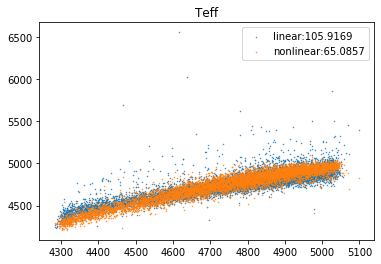

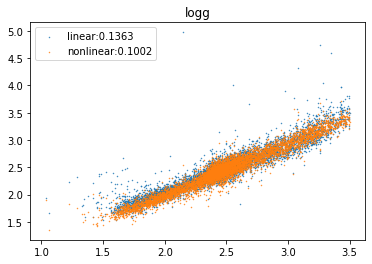

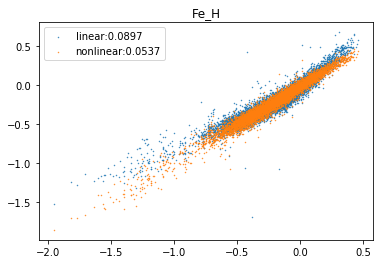

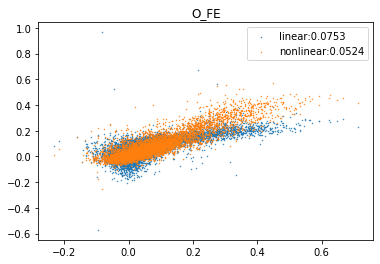

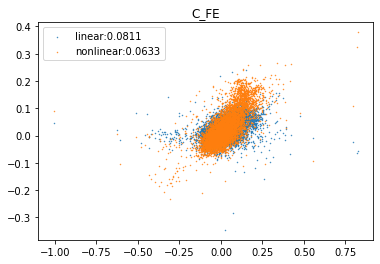

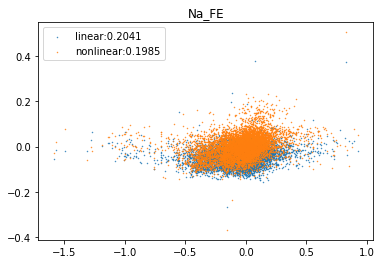

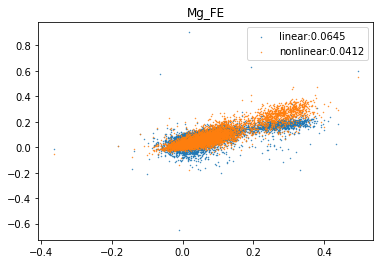

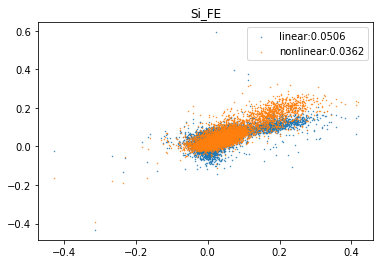

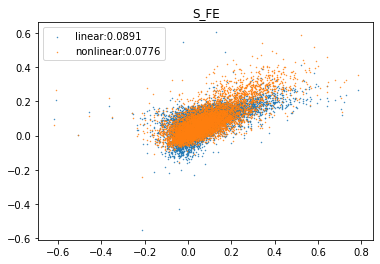

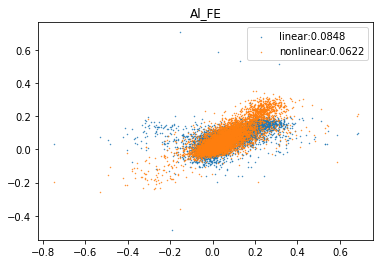

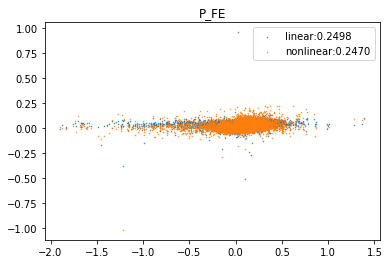

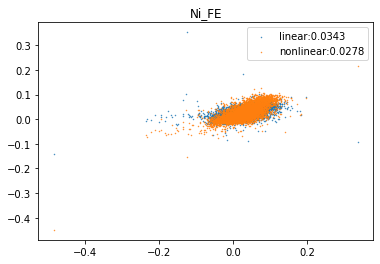

In [71]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])

    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.legend()
    plt.show()

In [72]:
y_astronn = vector.AstroNNVector(allStar[:n_data][combined_cut[:n_data]],considered_parameters)

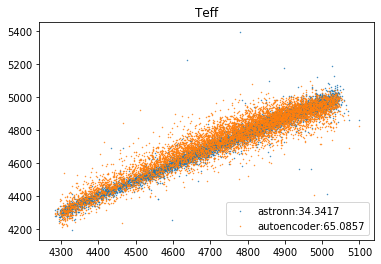

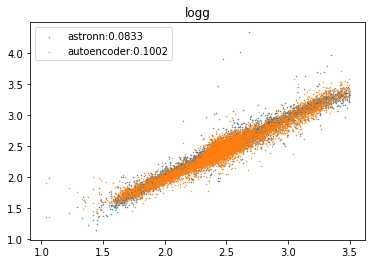

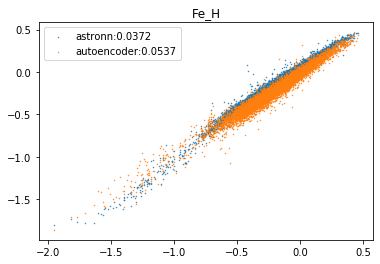

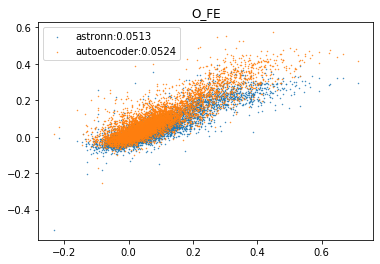

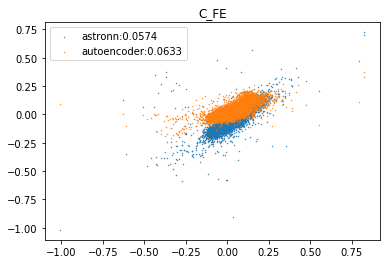

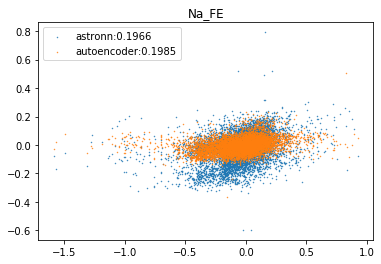

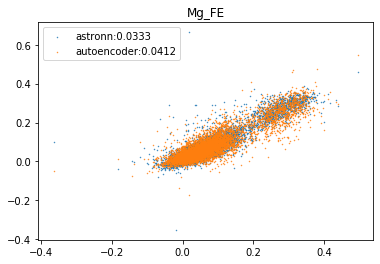

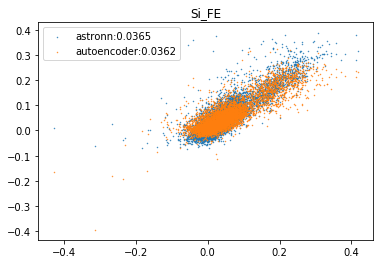

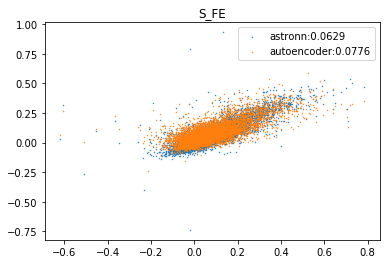

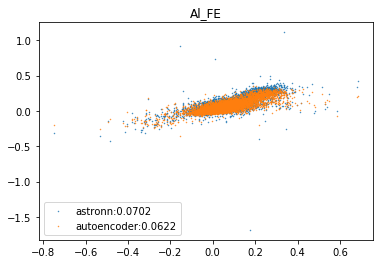

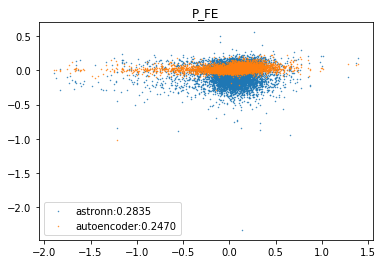

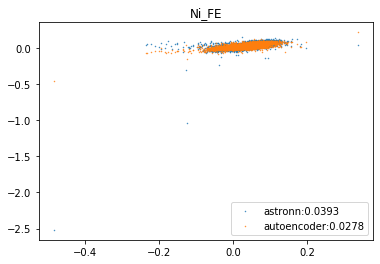

In [76]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])

    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(linear_std))
    plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="autoencoder:{:.4f}".format(nonlinear_std))
    plt.legend()
    plt.show()

In [ ]:
plt.plot(get_mask_elem("Mg"))
plt.xlim(1100,1150)

In [ ]:
i = 5
plt.title(considered_parameters[i])
plt.scatter(y.raw[:,2],y_astronn.raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))


In [ ]:
i = 5
plt.title(considered_parameters[i])
plt.scatter(y.raw[:,2],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))


In [ ]:
y_astronn.raw.shape

### Investigating chemical tagging as a method

Instead of using an autoencoder could we not just learn the biases in the data from applying the PCA procedure on astroNN abundances.

In [ ]:
from sklearn.decomposition import PCA


In [ ]:
whitener = PCA(n_components=12,whiten=True)



In [ ]:
whitener.fit(y_astronn.normalized)

In [ ]:
for i in range(12):
    plt.hist(y_astronn.normalized[:,i])
    plt.title(considered_parameters[i])
    plt.xlim(-1,1)
    plt.show()